 # Predicting running times based on air pollution

# Executive Summary

### Goal

The overall goal of this project was to investigate the effects of air quality on health, combining two of subjects of great interest to me; environment and health & fitness. 


### Background

In recent years with the outbreak of numerous new respiratory viruses, health has become a far greater concern for a significant proportion of the population than ever before.  Conversely, human effects on the environment and in turn those effects on human health, have been long documented and work to adjust this has increased in recent years -  just look at TfL's work on reducing air polution in London

Parkrun is a collection of 5-kilometre (3.1 mi) events for walkers, runners and volunteers that take place every Saturday morning at more than 2,000 locations in 22 countries across six continents. Parkrun events are free to enter and are delivered by volunteers, supported by a small group of staff at its headquarters.
In the UK they run over 700 locations, with all the recent and historic results on their website, including the age group, name and time of each runner


### Metrics

Regressor models were applied to predict running times, with R squared scores used to score and evaluate each model on both test and training data, along with noting the residuals and feature importances from specific models.


### What were your findings?

Unfortunately, none of the models scored particularly highly on test data, with the higest test R2 score being 0.24, suggesting the models were only able to account for approximately one quarter of all the observed variance. This is significantly below the generally accepted 65% value for models 
decision tree models were able score 0.96 on training data, however these models scored the lowest of all the models on on testing data.
Likewise, feature importances suggest that the greatest predictors were age and gender.


The overall findings are greatly affected by the running times being more easily affected by individual running ability that almost any other variable.  The data is also limited to those that ran only on those days.  If the air pollution was particularly high then those greatest affected by it - the elderly and those with cardiac or respicartory conditions are less likely to run as they would feel more restricted.  As such the data for this would be completely lacking and the models would be unable to include it

Furthermore, it is limited by the range of air quality and pollutant measurements that can be observed in the UK.  In future, air quality data and running times from a greater variety of countries and conditions could show more interesting findings

## Imports

In [1]:
#pip install geopandas
#pip install geopy
#pip install airpyllution
#pip install folium

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import time
import numpy as np
import pprint
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from time import time, sleep
import plotly.express as px
import folium
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Getting the data!

### List of all parkruns in the UK

If we are to scrape all the parkruns in the UK, we need to know where they all are, as well as what they are called.  This will allow us to use the name of the parkrun to find the results page and the location and county to get latitude and longitude for each run

In [16]:
#import csv of all parkruns in uk (taken from https://en.wikipedia.org/wiki/List_of_Parkruns_in_the_United_Kingdom#cite_note-13)

parkrun = pd.read_csv("parkruns.csv", index_col = 0)
parkrun.head()

,parkrun,location,county,first_run,Notes,lat,lon
0,alvaston,Alvaston,Derbyshire,25 May 2019,After several attempts to set up a Parkrun at ...,52.885106,-1.404343
1,ashbournerecreationground,Ashbourne,Derbyshire,7 May 2022,"The course, mostly flat grassy fields, is 3 la...",53.017333,-1.734273
2,beeston,Beeston,Nottinghamshire,5 Apr 2014,At the Weirfields Recreation Ground taking in ...,52.925720,-1.216189
3,beltonhouse,Belton,Lincolnshire,7 Nov 2011,In the grounds of The National Trust's Grade I...,53.556876,-0.812698
4,belvoircastle,Belvoir Castle,Leicestershire,15 Jan 2022,This out and back trail course has a permanent...,52.894693,-0.782689


In [ ]:
# use Nominatim to gather lat and long for each location and we can pass these to airpyllution in a bit

#nominatim needs both the place and the county, so create a list, places, of those
places_a = [x for x in parkrun.location]
places_b = [x for x in parkrun.county]
places = list(zip(places_a, places_b))

# create lists of lat and lon           
locator = Nominatim(user_agent= 'myGeocoder' )
lat = []
lon = []
# iterate through the list of place and county, appending the lat and longitude
for i in range(755):
    place = locator.geocode(places[i])
    try:
        lat.append(place.latitude)
        lon.append(place.longitude)
# Nominatim can't get coordinates for all, so these will have to be NaNs to be dropped in the dataframes later  
    except AttributeError:
        lat.append(np.nan)
        lon.append(np.nan)
# as well as not getting some coordinates, some places will be close enough that Nominatim cannot give
# different coords for each.  So we will have some duplicates.  But we'll deal with those in the dataframe

In [ ]:
# we can also use this to create a lat and lon col the parkrun df

parkrun["lat"] = lat
parkrun['lon'] = lon

In [ ]:
# get the locations from the parkrun col, remove instances of parkrun, spaces and any non letters
# create a list of all the cleaned up location names and that can be fed into the scraper
regex = re.compile('[^a-zA-Z]')
all_locations = [regex.sub("",x.replace('Parkrun', '').replace('parkrun', '').lower()) for x in parkrun.Parkrun]

In [6]:
len(all_locations)

755

In [7]:
# that's a lot of locations!  And 52 races for each location means almost 40,000 webpages.  We'll break it up
# into chunks to reduce the workload on the computer while scraping

chunk1 = all_locations[:75]
chunk2 = all_locations[75:145]
chunk3 = all_locations[150:225]
chunk4 = all_locations[225:300]
chunk5 = all_locations[300:375]
chunk6 = all_locations[375:450]
chunk7 = all_locations[450:525]
chunk8 = all_locations[525:600]
chunk9 = all_locations[600:675]
chunk10 = all_locations[675:775]

### Creating the parkrun scraper

In [8]:
# create a function to scrape runner's names from a results page on parkrun

def get_names(soup):
    names = []
    n = soup.find_all(target="_top")
    for i in n:
        names.append(i.text)
    return(names)

In [9]:
# create a function to scrape runner's age group (containing age range and gender) from a results page on parkrun

def get_agegroups(soup):
    age_group = []
    n = soup.find_all(class_="Results-table-td Results-table-td--ageGroup")
    for i in n:
        age_group.append(i.text[0:7])
    age_group = list(filter(lambda x: x != '\xa0', age_group))
    return(age_group)

In [10]:
# create a function to scrape runner's times from a results page on parkrun.  The time could be contained in one
# of three different classes depending on whether it was their first race or a pb or not

def get_times(soup):
    times = []
    a = soup.find_all(class_="Results-table-td Results-table-td--time")
    b = soup.find_all(class_="Results-table-td Results-table-td--time Results-table-td--pb")
    c = soup.find_all(class_="Results-table-td Results-table-td--time Results-table-td--ft")
    for i in a:
        times.append(i.text[0:5])
    for i in b:
        times.append(i.text[0:5])
    for i in c:
        times.append(i.text[0:5])
    times = list(filter(lambda x: x != '\xa0', times))
    times = sorted(times)
    return(times)

## Scraping parkruns website

In [37]:
#define list of locations and create loop to enter access most recent race results (change chunk number each time)
chunk = chunk1

locations = set(chunk)
for place in locations:
    url_template = f'https://www.parkrun.org.uk/{place}/results/latestresults/'
    driver = webdriver.Chrome()
    driver.get(url_template)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    # extract the race number to use to loop through past races.
    # try except clause if race number can't be accessed (generally locations that are no longer active)
    try:
        num = int(soup.h3.find("span").find_next().find_next().text.strip('#'))
    except AttributeError:
        continue
    # create a dictionary of the information using the above functions
    data = {'name' : get_names(soup),
            'age_group':get_agegroups(soup),
            'time' : get_times(soup),
            'location': place,
            'race_num' : num,
            'date' : soup.find(class_="format-date").text}
    # create df from this dictionary
    df = pd.concat([df,rawdf], ignore_index = True)
    # now to iterate through 52 next most recent races to get the whole year's races
    for x in list(range(1,52)):
        # create new race number using num extracted from latest result
        number = num - x
        # break the loop if number is less than 1 and go to next location
        if number < 1:
            break
        else:
            #new driver with the place and the new number
            driver = webdriver.Chrome()
            driver.get(f'https://www.parkrun.org.uk/{place}/results/{number}/')
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            # create a dictionary of the information using the above functions
            data = {'name' : get_names(soup),
                    'age_group':get_agegroups(soup),
                    'time' : get_times(soup),
                    'location': place,
                    'race_num' : number,
                    'date' : soup.find(class_="format-date").text}
            # create new df, unless the dictionary is of unequal lengths (this is sometimes caused by unusual coding with the race times)
            try:
                rawdf = pd.DataFrame(data)
            except ValueError:
                pass
        # add to df
        df = pd.concat([df,rawdf], ignore_index = True)
        sleep(1)
    number = 0
driver.quit()
df
#save this chunk to csv
df.to_csv(f"{chunk}.csv", index = False)

## Getting the Air Quality Data (AQI)

In [ ]:
# now we need to get some air quality data with airpyllution!
# the get functions allow us call the openweather api for air quality if we have dates and coordinates

from airpyllution.airpyllution import get_air_pollution
from airpyllution.airpyllution import get_pollution_history

In [ ]:
# create a df for air quality, we'll get the data from the air pyllution functions
aqi = pd.DataFrame()

# function needs UNIX timestamp, grabbed these easily from google 
start_date = 1641027600
end_date = 1672563600

#free api key from openweather
api_key = '88e1170f151f10d31487dd307f7e88f3'

#now loop through each set of coordinates to get the air quality measurements for all of 2022
for i in range(755):
    latitude = lat[i]
    longitude = lon[i]
# use the function to make the api call and return the information as a df    
    df = get_pollution_history(start_date, end_date, latitude, longitude, api_key)
# for lat and longs that are NaNs, the api call will return a string saying wrong latitude, so add in if clause here 
    if type(df) == str:
        pass
# if df is ok, filter the results we want (saturdayas at 9am since all parkruns are on saturdays and almost all start at 9)
    else:
        df['dt'] = pd.to_datetime(df.dt)
        df['day'] = df['dt'].dt.weekday
        df['hour'] = df['dt'].dt.hour
        df = df[df['day']==5]
        df = df[df['hour']==9]
        df['location'] = f'{places_a[i]}'    
        aqi = pd.concat([aqi,df], ignore_index = True)

## Cleaning AQI

In [18]:
# change the date form so it matches that in df
aqi['date'] = aqi['dt'].dt.normalize()

# drop unneeded cols
aqi.drop(['dt', 'day', 'hour'], inplace = True, axis=1)

#drop any duplicates created by the scraper (some parkrun locations are so close that Nominatim will give same lat and long)
aqi.drop_duplicates(inplace = True, ignore_index = True)

#drop any null values from age group or time
aqi.dropna(axis = 0, inplace = True)

# reset index
aqi.reset_index(inplace = True, drop = True)


## Cleaning scraped running data, joining with AQI

In [33]:
# each scraped

# load and clean!
df = pd.read_csv("chunk1.csv", parse_dates = ['date'], infer_datetime_format = True)

#drop any duplicates created by the scraper
df.drop_duplicates(inplace = True, ignore_index = True)

#drop any null values from age group or time
df.dropna(axis = 0, subset = ['time','age_group'], inplace = True)

# reset index
df.reset_index(inplace = True, drop = True)

df.head()

/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1063: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1063: UserWarning: Parsing '25/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1063: UserWarning: Parsing '24/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.p

,name,age_group,time,location,race_num,date
0,James PERRETT,SM30-34,18:10,hogmoorinclosure,181,2023-01-01
1,Duncan SELMES,SM30-34,18:18,hogmoorinclosure,181,2023-01-01
2,Richard WILLIAMS,SM30-34,18:24,hogmoorinclosure,181,2023-01-01
3,James TURNER,SM30-34,19:16,hogmoorinclosure,181,2023-01-01
4,Sam LARCOMBE,VM35-39,19:23,hogmoorinclosure,181,2023-01-01


In [34]:
# rename location col to parkrun so it matches up with parkruns df
df.rename(columns = {'location' : 'parkrun'}, inplace = True)

# create year col and then subset data to only 2022
df["year"] = df.date.dt.year
df = df[df.year==2022]

# reset index
df.reset_index(inplace = True, drop = True)

# extract gender - NOTE PARKRUNS RECORDS GENDER AS BINARY, THUS I AM TAKING GENDER AS BINARY
df['is_male'] = df['age_group'].map(lambda x: 1 if x[1] == 'M' else 0)

In [35]:
# time needs to be a float - minutes with decimal value -  and then we can filter out the incorrect times
times = []

for x in df.time:
    try:
        a = datetime.strptime(x,'%M:%S')
        times.append(a.minute + (a.second/60))
    except ValueError:
        times.append(np.nan)
        

df['time'] = times

In [36]:
# let's use the age range to create a median age to use as this will be easier for the models to utilise

med_age = []
for x in df['age_group']:
    if x[2:4]=='10':
        med_age.append(10.0)
    else:
        try:
            med_age.append((float(x[2:4]) + float(x[5:]))/2)
        except ValueError:
            med_age.append(np.nan)
df['med_age'] = med_age

In [37]:
# drop any NaNs created in the last two feature engineering stages
df.dropna(axis = 0, subset = ['time','age_group', 'med_age'], inplace = True)

In [38]:
#get the parkrun df ready for the join
#a bit of regex on the Parkrun column as we did earlier
regex = re.compile('[^a-zA-Z]')
parkrun['Parkrun'] = [regex.sub("",x.replace('Parkrun', '').replace('parkrun', '').lower()) for x in parkrun.Parkrun]

#rename the parkrun col
parkrun.rename(columns = {'Parkrun' : 'parkrun', 'Location' : 'location'}, inplace = True)


# join df and parkruns on parkrun
df = df.merge(parkrun, how = 'left', on = 'parkrun')

# remove cols that aren't needed
df.drop(['age_group', 'county','first_run', 'Notes'], axis=1, inplace = True)
df.head()


,name,time,parkrun,race_num,date,year,is_male,med_age,location
0,James BAKER,17.183333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill
1,Jon FAIRS,19.483333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill
2,Aaron HICKEY,20.750000,hogmoorinclosure,180,2022-12-31,2022,1,18.5,Whitehill
3,Oliver BARLOW,21.233333,hogmoorinclosure,180,2022-12-31,2022,1,37.0,Whitehill
4,Catherine SEAGER,21.600000,hogmoorinclosure,180,2022-12-31,2022,0,42.0,Whitehill


In [40]:
# merge df and aqi on date and location
airruns = pd.merge(df, aqi, on=['date', 'location'], how='left')

#drop duplicates and NAs
airruns.drop_duplicates(subset = ['name', 'time','parkrun', 'race_num', 'date'], inplace = True, ignore_index = True)
airruns.dropna(inplace = True)


,name,time,parkrun,race_num,date,year,is_male,med_age,location,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,James BAKER,17.183333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill,193.6,0.00,4.16,67.23,2.00,3.56,4.59,0.06
1,Jon FAIRS,19.483333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill,193.6,0.00,4.16,67.23,2.00,3.56,4.59,0.06
2,Aaron HICKEY,20.750000,hogmoorinclosure,180,2022-12-31,2022,1,18.5,Whitehill,193.6,0.00,4.16,67.23,2.00,3.56,4.59,0.06
3,Oliver BARLOW,21.233333,hogmoorinclosure,180,2022-12-31,2022,1,37.0,Whitehill,193.6,0.00,4.16,67.23,2.00,3.56,4.59,0.06
4,Catherine SEAGER,21.600000,hogmoorinclosure,180,2022-12-31,2022,0,42.0,Whitehill,193.6,0.00,4.16,67.23,2.00,3.56,4.59,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588777,David ARCHER,42.100000,prudhoeriverside,219,2022-07-16,2022,1,77.0,Prudhoe,145.2,1.49,2.08,31.83,0.65,2.00,3.39,2.37
588778,Nicole ROBSON,42.116667,prudhoeriverside,219,2022-07-16,2022,0,27.0,Prudhoe,145.2,1.49,2.08,31.83,0.65,2.00,3.39,2.37
588779,Gareth TUDOR,43.166667,prudhoeriverside,219,2022-07-16,2022,1,77.0,Prudhoe,145.2,1.49,2.08,31.83,0.65,2.00,3.39,2.37
588780,Isabelle TUDOR,43.183333,prudhoeriverside,219,2022-07-16,2022,0,77.0,Prudhoe,145.2,1.49,2.08,31.83,0.65,2.00,3.39,2.37


In [41]:
# that worked, so let's repeat the steps with a loop
# then concatenate each resulting dataframe:

for i in range(2,11):

    df = pd.read_csv(f"chunk{num}.csv", parse_dates = ['date'], infer_datetime_format = True)

    #drop any duplicates created by the scraper
    df.drop_duplicates(inplace = True, ignore_index = True)

    #drop any null values from age group or time
    df.dropna(axis = 0, subset = ['time','age_group'], inplace = True)

    # reset index
    df.reset_index(inplace = True, drop = True)

    # rename location col to parkrun so it matches up with parkruns df
    df.rename(columns = {'location' : 'parkrun'}, inplace = True)

    # create year col and then subset data to only 2022
    df["year"] = df.date.dt.year
    df = df[df.year==2022]

    # reset index
    df.reset_index(inplace = True, drop = True)

    # extract gender and age range, take mean value of age from range
    df['is_male'] = df['age_group'].map(lambda x: 1 if x[1] == 'M' else 0)

    # time as a float
    times = []

    for x in df.time:
        try:
            a = datetime.strptime(x,'%M:%S')
            times.append(a.minute + (a.second/60))
        except ValueError:
            times.append(np.nan)
        
    df['time'] = times

    # median age
    med_age = []
    for x in df['age_group']:
        if x[2:4]=='10':
            med_age.append(10.0)
        else:
            try:
                med_age.append((float(x[2:4]) + float(x[5:]))/2)
            except ValueError:
                med_age.append(np.nan)
    df['med_age'] = med_age

    # drop any NaNs created in the last two feature engineering stages
    df.dropna(axis = 0, subset = ['time','age_group', 'med_age'], inplace = True)

    # join df and parkruns on parkrun
    df = df.merge(parkrun, how = 'left', on = 'parkrun')

    # remove cols that aren't needed
    df.drop(['age_group', 'county','first_run', 'Notes'], axis=1, inplace = True)

    # merge df and aqi on date and location
    df = pd.merge(df, aqi, on=['date', 'location'], how='left')

    #drop duplicates and NAs
    df.drop_duplicates(subset = ['name', 'time','parkrun', 'race_num', 'date'], inplace = True, ignore_index = True)
    df.dropna(inplace = True)

    # concatenate with the other cleaned and join data
    airruns = pd.concat([airruns, df], ignore_index = True)

# now drop any duplicates
airruns.drop_duplicates(subset = ['name', 'time', 'parkrun', 'date'], inplace = True, ignore_index = True)


/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1063: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1063: UserWarning: Parsing '25/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1063: UserWarning: Parsing '24/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/jonathanyirrell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.p

,name,time,parkrun,race_num,date,year,is_male,med_age,location
0,James BAKER,17.183333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill
1,Jon FAIRS,19.483333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill
2,Aaron HICKEY,20.750000,hogmoorinclosure,180,2022-12-31,2022,1,18.5,Whitehill
3,Oliver BARLOW,21.233333,hogmoorinclosure,180,2022-12-31,2022,1,37.0,Whitehill
4,Catherine SEAGER,21.600000,hogmoorinclosure,180,2022-12-31,2022,0,42.0,Whitehill


In [81]:
#check for nas
airruns.isna().sum()

name                0
time                0
parkrun             0
race_num            0
date                0
year                0
is_male             0
med_age             0
location            0
co                  0
no                  0
no2                 0
o3                  0
so2                 0
pm2_5               0
pm10                0
nh3                 0
Unnamed: 0    2327984
dtype: int64

In [86]:
# looks like an issue with one of the old indexes being duplicated. Let's get rid
airruns.drop(['first_run', 'Notes', 'Unnamed: 0'], axis = 1, inplace = True)
airruns.tail()

,name,time,parkrun,race_num,date,year,is_male,med_age,location,co,no,no2,o3,so2,pm2_5,pm10,nh3
4351827,Liz ABEL,51.550000,dartford,300,2022-01-08,2022,0,77.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13
4351828,Henry ARNOULD,51.566667,dartford,300,2022-01-08,2022,1,10.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13
4351829,Lilly ARNOULD,51.600000,dartford,300,2022-01-08,2022,0,10.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13
4351830,Rebecca ARNOULD,51.616667,dartford,300,2022-01-08,2022,0,42.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13
4351831,Deirdre ARNOULD,51.766667,dartford,300,2022-01-08,2022,0,62.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13


In [133]:
#let's save that to a csv to make sure we don't lose anything!
airruns.to_csv("airruns.csv")

# EDA!

In [2]:
airruns = pd.read_csv("airruns.csv")
airruns.drop('Unnamed: 0', axis = 1, inplace = True)
airruns

,name,time,parkrun,race_num,date,year,is_male,med_age,location,co,no,no2,o3,so2,pm2_5,pm10,nh3,county,lat,lon
0,James BAKER,17.183333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill,193.60,0.0,4.16,67.23,2.00,3.56,4.59,0.06,Hampshire,51.097719,-0.864067
1,Jon FAIRS,19.483333,hogmoorinclosure,180,2022-12-31,2022,1,47.0,Whitehill,193.60,0.0,4.16,67.23,2.00,3.56,4.59,0.06,Hampshire,51.097719,-0.864067
2,Aaron HICKEY,20.750000,hogmoorinclosure,180,2022-12-31,2022,1,18.5,Whitehill,193.60,0.0,4.16,67.23,2.00,3.56,4.59,0.06,Hampshire,51.097719,-0.864067
3,Oliver BARLOW,21.233333,hogmoorinclosure,180,2022-12-31,2022,1,37.0,Whitehill,193.60,0.0,4.16,67.23,2.00,3.56,4.59,0.06,Hampshire,51.097719,-0.864067
4,Catherine SEAGER,21.600000,hogmoorinclosure,180,2022-12-31,2022,0,42.0,Whitehill,193.60,0.0,4.16,67.23,2.00,3.56,4.59,0.06,Hampshire,51.097719,-0.864067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351827,Liz ABEL,51.550000,dartford,300,2022-01-08,2022,0,77.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13,Kent,51.444306,0.218070
4351828,Henry ARNOULD,51.566667,dartford,300,2022-01-08,2022,1,10.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13,Kent,51.444306,0.218070
4351829,Lilly ARNOULD,51.600000,dartford,300,2022-01-08,2022,0,10.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13,Kent,51.444306,0.218070
4351830,Rebecca ARNOULD,51.616667,dartford,300,2022-01-08,2022,0,42.0,Dartford,236.99,0.0,10.62,59.37,3.07,2.87,3.32,0.13,Kent,51.444306,0.218070


In [310]:
airruns.describe()

,time,race_num,year,is_male,med_age,co,no,no2,o3,so2,pm2_5,pm10,nh3,lat,lon
count,4.351832e+06,4.351832e+06,4351832.0,4.351832e+06,4.351832e+06,4.351832e+06,4.351832e+06,4.351832e+06,4.351832e+06,4.351832e+06,4.351832e+06,4.351832e+06,4.351832e+06,4.297646e+06,4.297646e+06
mean,2.955630e+01,3.090844e+02,2022.0,5.842863e-01,4.409724e+01,2.129966e+02,2.334804e+00,8.533912e+00,5.250520e+01,2.772848e+00,6.001473e+00,8.375970e+00,1.823119e+00,5.216439e+01,-4.245238e+00
std,7.128401e+00,1.670749e+02,0.0,4.928447e-01,1.528282e+01,4.681162e+01,6.698156e+00,8.173558e+00,1.931211e+01,2.854213e+00,7.621244e+00,8.669665e+00,3.182019e+00,2.528229e+00,1.339106e+01
min,1.393333e+01,1.000000e+00,2022.0,0.000000e+00,1.000000e+01,9.930000e+01,0.000000e+00,1.200000e-01,0.000000e+00,3.000000e-02,5.000000e-01,5.100000e-01,0.000000e+00,3.599665e+01,-7.890181e+01
25%,2.463333e+01,1.680000e+02,2022.0,0.000000e+00,3.200000e+01,1.769100e+02,7.000000e-02,3.340000e+00,4.005000e+01,1.040000e+00,1.790000e+00,2.960000e+00,5.400000e-01,5.136063e+01,-2.699272e+00
50%,2.835000e+01,3.250000e+02,2022.0,1.000000e+00,4.700000e+01,2.002700e+02,4.800000e-01,6.000000e+00,5.579000e+01,1.890000e+00,3.190000e+00,5.270000e+00,1.080000e+00,5.229134e+01,-1.543794e+00
75%,3.293333e+01,4.380000e+02,2022.0,1.000000e+00,5.700000e+01,2.436600e+02,1.790000e+00,1.062000e+01,6.580000e+01,3.430000e+00,6.550000e+00,1.049000e+01,2.180000e+00,5.348153e+01,-6.272301e-01
max,5.998333e+01,7.440000e+02,2022.0,1.000000e+00,9.700000e+01,6.008100e+02,1.198100e+02,6.992000e+01,1.258900e+02,4.387000e+01,8.157000e+01,8.877000e+01,1.621200e+02,6.014612e+01,1.753764e+00


Time has a huge range! from just under 14 minutes to just under an hour! But 50% of the values come between 14 and 28 minutes and 75% between 14 and 33 minutes.  Which suggests a lot of 'outliers' outside of upper confidence value.  So it's not normally distributed, but also are these outliers really anomalous? More likely they are due to parkrun being open to people of all ability levels.

All our observations are from 2022, which is a good check for our earlier cleaning

We have runners as young as 10 and as old as 97! (we'll come back to that in a bit!) and a good spread of ages, with a mean of 44 and range of 87 years!

Majority of observations for men?

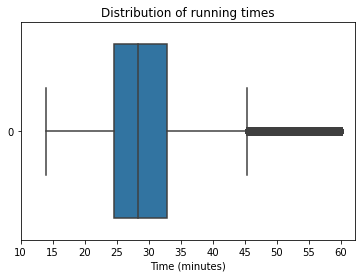

In [23]:
ax = sns.boxplot(data=airruns.time, orient="h")
ax.set(title = "Distribution of running times", xlabel = "Time (minutes)")
ax.set_xticks(range(10,65, 5));

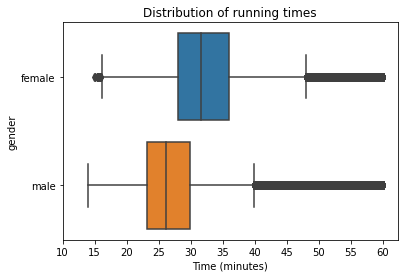

In [16]:
# does gender generally affect running time? (again, remember parkrun records gender as binary)
ax = sns.boxplot(data=airruns, x = 'time', y = 'is_male', orient="h")
ax.set(title = "Distribution of running times", xlabel = "Time (minutes)", ylabel = 'gender')
ax.set_yticklabels(['female', 'male'])
ax.set_xticks(range(10,65, 5));

Gender seems to have an affect on running time.  On average men are faster,with a lower median time, but a larger range as there's plenty of men running the slower times

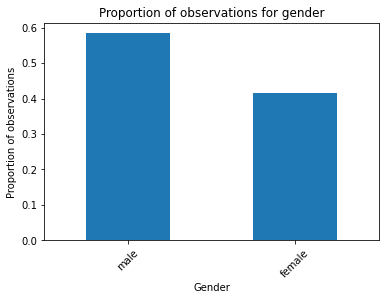

In [43]:
# have we got an equal number of observations for male and female?
airruns['is_male'].value_counts(normalize = True).plot(kind = 'bar')
plt.xticks(ticks = [0,1], labels = ['male', "female"], rotation = 45)
plt.xlabel("Gender")
plt.ylabel("Proportion of observations")
plt.title("Proportion of observations for gender")
plt.show();

So more men running that women, almost 60% of our dataset is male

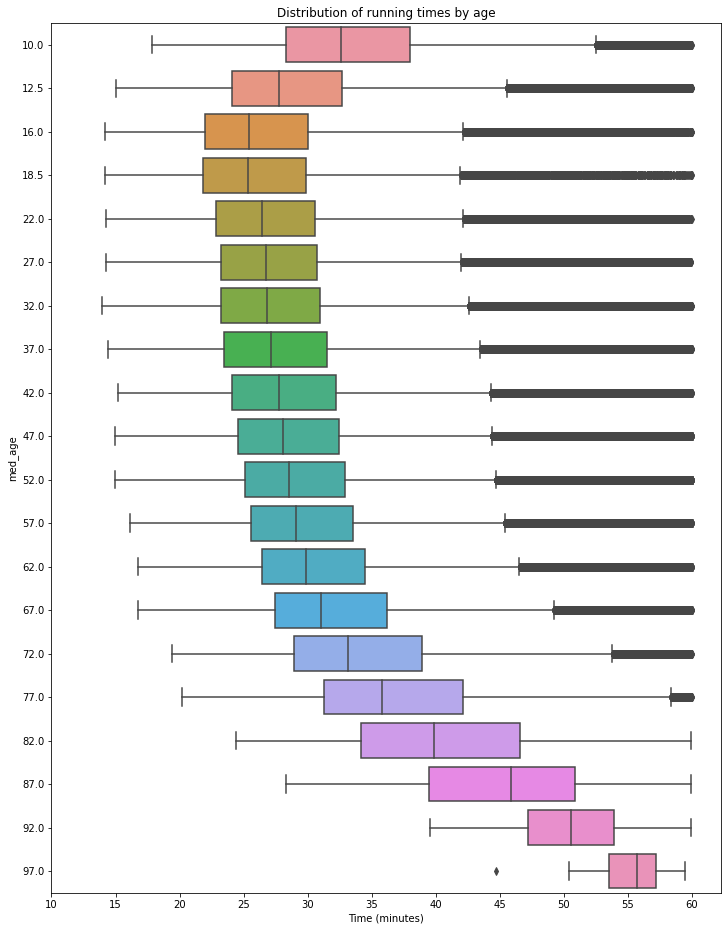

In [7]:
fig, ax = plt.subplots(figsize=(12, 16))
ax = sns.boxplot(data=airruns, x = 'time', y = 'med_age', orient="h")
ax.set(title = "Distribution of running times by age", xlabel = "Time (minutes)", ylabel = 'med_age')
ax.set_xticks(range(10,65, 5));

In [8]:
airruns.groupby('is_male')['time'].mean()

is_male
0    32.812655
1    27.239436
Name: time, dtype: float64

In [13]:
airruns[airruns.med_age < 11].name.nunique()

23835

In [11]:
airruns[airruns.med_age > 90].name.nunique()

20

Runners in their 90s? And at least one around 97 years old?! And a run under 45 minutes? Need to learn more about these over 90s runners!!

## Over 90s runners!!

In [227]:
nineties = airruns[airruns.med_age > 90]

In [228]:
nineties

,name,time,parkrun,race_num,date,year,is_male,med_age,location,co,no,no2,o3,so2,pm2_5,pm10,nh3,county,lat,lon
76360,John BUTCHER,51.233333,dunstabledowns,97,2022-07-23,2022,1,92.0,Dunstable,158.55,1.49,4.84,35.76,1.15,4.78,6.29,1.87,Bedfordshire,51.886132,-0.520934
187775,John BUTCHER,54.916667,aldenham,299,2022-07-30,2022,1,92.0,Elstree,185.25,4.30,18.68,63.66,11.21,12.93,15.48,1.19,Hertfordshire,51.643773,-0.298935
272495,John BUTCHER,44.200000,markshallestate,8,2022-01-15,2022,1,92.0,Coggeshall,433.92,0.88,38.04,6.53,4.17,35.50,37.94,0.34,Essex,51.881863,0.681875
426216,John BUTCHER,47.233333,rickmansworth,233,2022-12-31,2022,1,92.0,Rickmansworth,191.93,0.00,6.34,60.08,2.15,2.29,2.54,0.09,Hertfordshire,51.640184,-0.473405
429202,John BUTCHER,44.600000,rickmansworth,219,2022-09-24,2022,1,92.0,Rickmansworth,206.95,4.19,15.25,26.46,4.89,7.70,10.93,0.99,Hertfordshire,51.640184,-0.473405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256937,Dermot LYNCH,56.983333,hazelwood,130,2022-03-19,2022,1,92.0,Sunbury-on-Thames,287.06,3.69,17.14,59.37,9.06,20.74,23.31,4.24,Surrey,51.407707,-0.411859
4257541,Dermot LYNCH,52.416667,hazelwood,126,2022-02-19,2022,1,92.0,Sunbury-on-Thames,253.68,0.16,6.08,62.94,1.74,0.71,1.58,2.06,Surrey,51.407707,-0.411859
4257657,Dermot LYNCH,53.516667,hazelwood,125,2022-02-12,2022,1,92.0,Sunbury-on-Thames,257.02,0.09,7.71,66.52,2.65,3.89,5.12,1.03,Surrey,51.407707,-0.411859
4257994,Dermot LYNCH,53.683333,hazelwood,122,2022-01-22,2022,1,92.0,Sunbury-on-Thames,297.07,1.47,37.36,18.24,5.19,6.36,8.15,0.46,Surrey,51.407707,-0.411859


So over 280 runs by people over 90 years old in 2022.  You don't stop moving because you get old, you get old because you stop moving!

Anyway what were their names, where were they running, what was the average run time etc??

In [287]:
nineties.name.nunique()

20

In [229]:
nineties.name.value_counts()

Geoff JACKSON               43
Harold MESSAM               38
Marie PALMER                35
Dermot LYNCH                33
Robert M. WALSH             31
Grace CHAMBERS              28
Arthur J. WALSHAM           23
John BUTCHER                14
Ajit DOSANJH                12
Graham BROOKS               11
Ken LEGGETT                  4
Maurice THOMAS               2
Michael PARR                 2
Edward JONES                 1
Faith HAYES                  1
Eileen BEDWELL               1
Albert YEE                   1
Eileen STEWART               1
Richard PITCAIRN-KNOWLES     1
Rosemary MOORE               1
Name: name, dtype: int64

In [245]:
nineties.groupby('name')['time'].mean().sort_values()

name
Rosemary MOORE              42.166667
Maurice THOMAS              42.908333
Edward JONES                44.750000
Ajit DOSANJH                47.083333
John BUTCHER                47.121429
Grace CHAMBERS              48.000000
Marie PALMER                48.732857
Richard PITCAIRN-KNOWLES    49.500000
Michael PARR                49.600000
Robert M. WALSH             50.515591
Graham BROOKS               51.477273
Arthur J. WALSHAM           51.867391
Ken LEGGETT                 51.870833
Geoff JACKSON               52.470543
Eileen BEDWELL              53.416667
Dermot LYNCH                53.796465
Harold MESSAM               55.471491
Eileen STEWART              57.233333
Faith HAYES                 57.716667
Albert YEE                  58.050000
Name: time, dtype: float64

In [244]:
nineties[nineties.med_age == 97].name.value_counts()

Harold MESSAM    37
Name: name, dtype: int64

20 90 year-olds ran last year, with Geoff Jackson only missing 9 runs! That's dedication.

While Harold Mesham is our oldest runner (and second most frequent over 90s runner!)

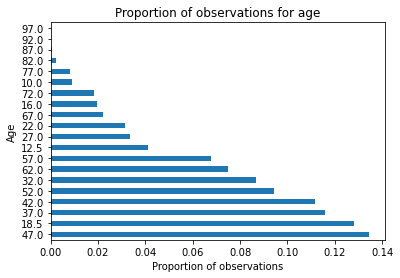

In [47]:
# whats the age breakdown of the whole dataframe?
airruns['med_age'].value_counts(normalize = True).plot(kind = 'barh')
plt.yticks(ticks = range(airruns['med_age'].nunique()), labels = (airruns['med_age'].unique()), rotation =0)
plt.ylabel("Age")
plt.xlabel("Proportion of observations")
plt.title("Proportion of observations for age")
plt.show();

In [14]:
fastest = pd.DataFrame(airruns.groupby('parkrun')['time'].mean().sort_values())
fastest.head(20)

,time
parkrun,
lowerdrummans,25.634524
blackcombe,25.746667
dulwich,26.090507
hackneymarshes,26.645634
belfastvictoria,26.711147
brockwell,26.831223
coldhamscommon,26.886227
highburyfields,26.959770
elderpark,26.963636


In [262]:
fastest.tail(20)

,time
parkrun,
shipleycountry,31.909790
cliffecastle,31.925906
bestwoodvillage,31.945709
thurrock,31.962122
belvoircastle,32.023926
sandwellvalley,32.063339
hafanpwllheli,32.331634
thurso,32.502197
cranleigh,32.525862


In [17]:
# bring the lat and lon data back
fastest = fastest.merge(parkrun, how = 'left', on = 'parkrun')
fastest.dropna(inplace = True)
fastest.head()

,parkrun,time,location,county,first_run,Notes,lat,lon
0,lowerdrummans,25.634524,Magilligan Prison,Northern Ireland,6 Jan 2018,This event takes place within the grounds of a...,55.176145,-6.949282
1,blackcombe,25.746667,Haverigg,Cumbria,4 Nov 2017,Takes place within the closed grounds of HM Pr...,54.197081,-3.288220
2,dulwich,26.090507,Dulwich Park,Southwark,14 Apr 2012,Three anti-clockwise laps on tarmac paths,51.445723,-0.078350
3,hackneymarshes,26.645634,Hackney Marshes,Hackney,29 May 2010,A flat course taking in the River Lea and the ...,51.556496,-0.029172
4,belfastvictoria,26.711147,Belfast,Belfast,7 May 2011,At Victoria Park comprising three outer laps o...,46.078575,-62.878395


The average time for whole dataset is 29.55 mins, but clearly have some that are 'faster' and some that are 'slower'
Having looked up blackcombe and lower drummans parks, turns out that they are both parkruns for prisons allowing only authorised runners to take part.  As such there's only a few (fewer than 50) finishers each week and even fewer in my dataframe as many do not have listed gender or age details so were dropped in earlier cleaning.

(Likely this information is not entered for secuirty or data protection reasons.  Or perhaps they just want to be discrete!)


In [223]:
# are some of the 'faster' parkruns down to low number of observations?
len(airruns[airruns.parkrun=='lowerdrummans'])
for run in fastest.parkrun[:20]:
    x = len(airruns[airruns.parkrun==f'{run}'])
    print(f'there are {x} observations for {run}')

there are 14 observations for lowerdrummans
there are 40 observations for blackcombe
there are 11846 observations for dulwich
there are 7680 observations for hackneymarshes
there are 8443 observations for belfastvictoria
there are 6143 observations for brockwell
there are 11554 observations for coldhamscommon
there are 13409 observations for highburyfields
there are 1815 observations for elderpark
there are 19251 observations for hovepromenade
there are 8016 observations for mileend
there are 2985 observations for greenock
there are 10696 observations for alexandra
there are 12368 observations for southmanchester
there are 14320 observations for southwark
there are 2241 observations for ruchill
there are 13176 observations for universityparks
there are 10081 observations for peckhamrye
there are 11384 observations for edinburgh
there are 2227 observations for aberbeeg


In [225]:
# are some of the 'slower' parkruns down to low number of observations?
len(airruns[airruns.parkrun=='lowerdrummans'])
for run in fastest.parkrun[-20:]:
    x = len(airruns[airruns.parkrun==f'{run}'])
    print(f'there are {x} observations for {run}')

there are 6357 observations for shipleycountry
there are 4376 observations for cliffecastle
there are 4288 observations for bestwoodvillage
there are 3414 observations for thurrock
there are 4968 observations for belvoircastle
there are 4548 observations for sandwellvalley
there are 2001 observations for hafanpwllheli
there are 1881 observations for thurso
there are 58 observations for cranleigh
there are 4219 observations for southall
there are 3399 observations for whinlatterforest
there are 3101 observations for chaddertonhall
there are 7889 observations for rosliston
there are 1384 observations for faskallyforest
there are 4996 observations for woolacombedunes
there are 1899 observations for cotsfordfields
there are 4191 observations for witton
there are 2514 observations for hadleigh
there are 3798 observations for durlstoncountrypark
there are 1726 observations for colinglen


In [18]:
#plot this on a folium plot, with different colour markers for the fastest 100 and slowest 100 parkrunss:
import folium
ukmap = folium.Map(location = [parkrun.lat.mean(), parkrun.lon.mean()], zoom_start =5)
# fastest 100, use green with a fast forward icon
for i in range(0,100):
    folium.Marker(location=[fastest.iloc[i]['lat'], fastest.iloc[i]['lon']],
    popup=fastest.iloc[i]['parkrun'], icon=folium.Icon(color='green', icon = 'forward-fast', prefix='fa')).add_to(ukmap)
# slowest 100, red with a rewind icon
for i in range(517,617):
    folium.Marker(location=[fastest.iloc[i]['lat'], fastest.iloc[i]['lon']],
    popup=fastest.iloc[i]['parkrun'], icon=folium.Icon(color='red', icon = 'backward-step', prefix='fa')).add_to(ukmap)
#all the others, blue with a circle
#for i in range(100,517):
    #folium.Marker(location=[fastest.iloc[i]['lat'], fastest.iloc[i]['lon']],
    #popup=fastest.iloc[i]['parkrun'], icon=folium.Icon(color='blue', icon = 'circle', prefix='fa')).add_to(ukmap)

In [19]:
ukmap

In [177]:
# doesn't look to be a huge correlation with areas - although Glasgow and Edinburgh seem to be very quick!

aqi.describe()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,34476.000000,34476.000000,34476.000000,34476.000000,34476.000000,34476.000000,34476.000000,34476.000000
mean,213.251588,2.111777,8.380560,53.012546,2.739635,5.716681,7.941442,1.752979
std,47.978281,6.170592,8.755227,19.382413,3.079943,7.536181,8.556861,3.037803
min,99.300000,0.000000,0.120000,0.000000,0.030000,0.500000,0.510000,0.000000
25%,176.910000,0.050000,2.960000,41.130000,0.900000,1.660000,2.730000,0.510000
50%,201.940000,0.390000,5.650000,55.790000,1.710000,3.000000,4.940000,1.000000
75%,243.660000,1.580000,10.370000,66.520000,3.370000,6.110000,9.890000,2.090000
max,988.010000,119.810000,70.600000,125.890000,43.870000,81.570000,88.770000,162.120000


In [260]:
airruns = pd.read_csv("airruns.csv", parse_dates = True)
airruns.drop('Unnamed: 0', axis = 1, inplace = True)

In [259]:
#aqi = pd.read_csv('airqualitydata.csv', parse_dates = ['dt'])
#  change the date form so it matches that in df
#aqi['date'] = aqi['dt'].dt.normalize()

#  drop unneeded cols
#aqi.drop(['dt', 'day', 'hour'], inplace = True, axis=1)

#  drop any duplicates created by the scraper (some parkrun locations are so close that Nominatim will give same lat and long)
#aqi.drop_duplicates(inplace = True, ignore_index = True)

# drop any null values from age group or time
#aqi.dropna(axis = 0, inplace = True)

# reset index
#aqi.reset_index(inplace = True, drop = True)

#aqi.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,location,date
0,216.96,0.00,3.98,61.51,1.34,5.77,10.12,0.72,Alvaston,2022-01-01
1,226.97,0.00,5.31,65.09,1.64,2.14,2.38,0.31,Alvaston,2022-01-08
2,317.10,0.43,33.24,12.87,7.75,25.76,27.64,3.93,Alvaston,2022-01-15
3,253.68,0.04,10.97,57.22,2.38,2.62,4.45,0.78,Alvaston,2022-01-22
4,230.31,0.00,2.68,64.37,0.79,1.41,2.45,0.42,Alvaston,2022-01-29


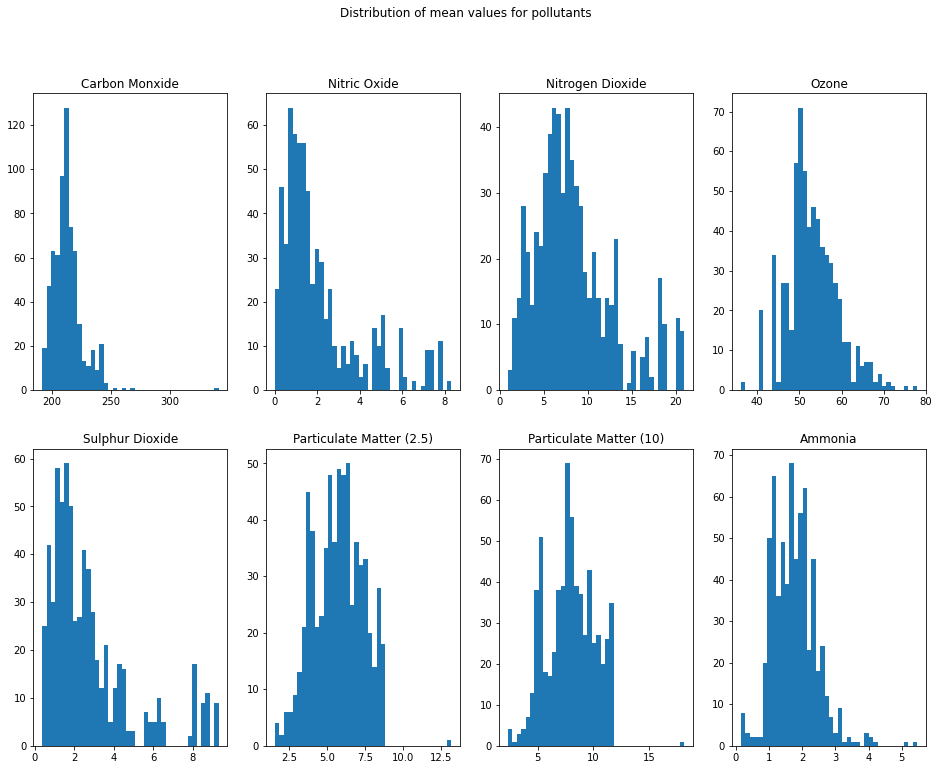

In [236]:
fig, ax = plt.subplots(nrows =2, ncols = 4, figsize = (16,12))
fig.suptitle("Distribution of mean values for pollutants")
ax[0,0].hist(aqi.groupby('location')['co'].mean(), bins = 40)
ax[0,0].set_title("Carbon Monxide")
ax[0,1].hist(aqi.groupby('location')['no'].mean(), bins = 40)
ax[0,1].set_title("Nitric Oxide")
ax[0,2].hist(aqi.groupby('location')['no2'].mean(), bins = 40)
ax[0,2].set_title("Nitrogen Dioxide")
ax[0,3].hist(aqi.groupby('location')['o3'].mean(), bins = 40)
ax[0,3].set_title("Ozone")
ax[1,0].hist(aqi.groupby('location')['so2'].mean(), bins = 40)
ax[1,0].set_title("Sulphur Dioxide")
ax[1,1].hist(aqi.groupby('location')['pm2_5'].mean(), bins = 40)
ax[1,1].set_title("Particulate Matter (2.5)")
ax[1,2].hist(aqi.groupby('location')['pm10'].mean(), bins = 40)
ax[1,2].set_title("Particulate Matter (10)")
ax[1,3].hist(aqi.groupby('location')['nh3'].mean(), bins = 40)
ax[1,3].set_title("Ammonia")
plt.show();

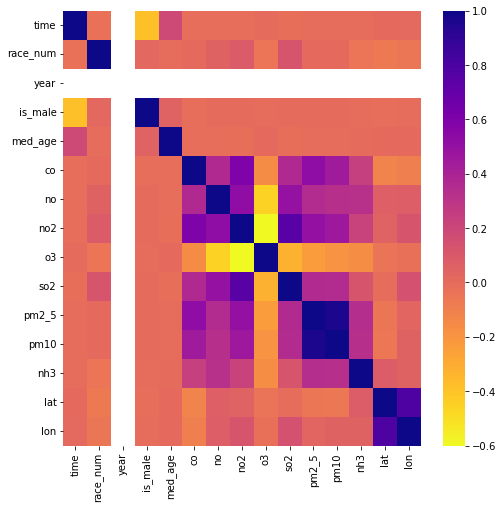

In [19]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.heatmap(airruns.corr(),cmap = 'plasma_r')
plt.show();

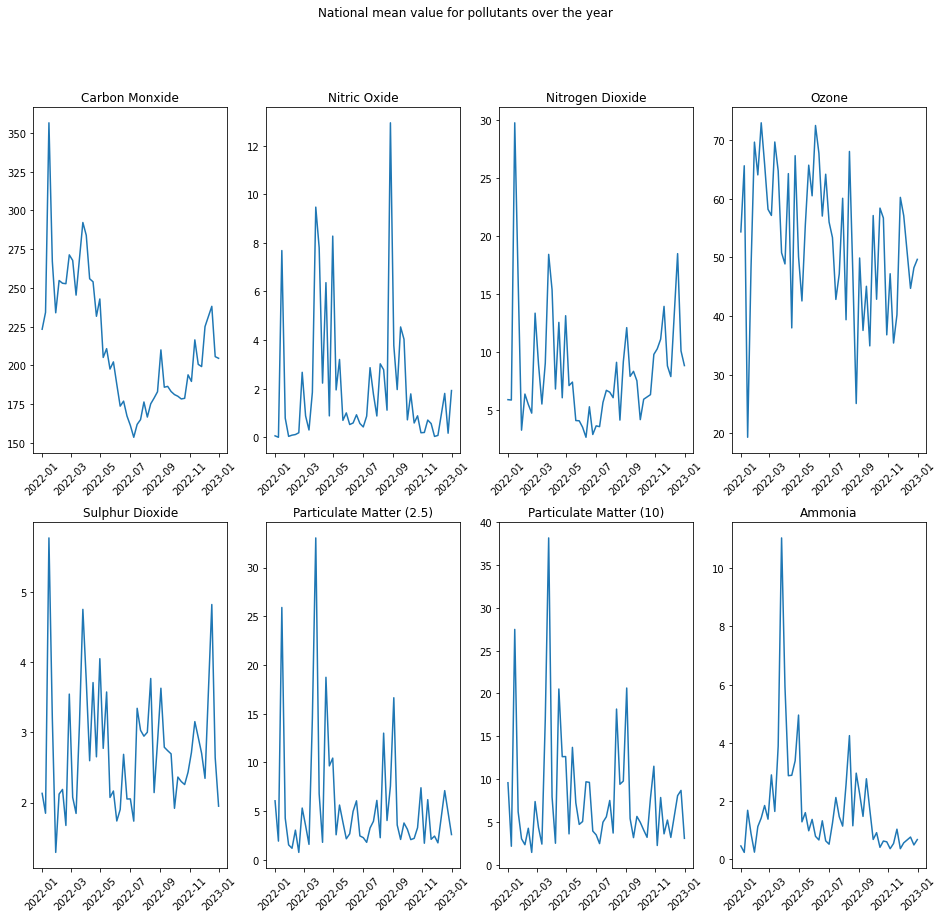

In [247]:
fig, ax = plt.subplots(nrows =2, ncols = 4, figsize = (16,14))
fig.suptitle("National mean value for pollutants over the year")
ax[0,0].plot(aqi.groupby('date')['co'].mean())
ax[0,0].set_title("Carbon Monxide")
ax[0,1].plot(aqi.groupby('date')['no'].mean())
ax[0,1].set_title("Nitric Oxide")
ax[0,2].plot(aqi.groupby('date')['no2'].mean())
ax[0,2].set_title("Nitrogen Dioxide")
ax[0,3].plot(aqi.groupby('date')['o3'].mean())
ax[0,3].set_title("Ozone")
ax[1,0].plot(aqi.groupby('date')['so2'].mean())
ax[1,0].set_title("Sulphur Dioxide")
ax[1,1].plot(aqi.groupby('date')['pm2_5'].mean())
ax[1,1].set_title("Particulate Matter (2.5)")
ax[1,2].plot(aqi.groupby('date')['pm10'].mean())
ax[1,2].set_title("Particulate Matter (10)")
ax[1,3].plot(aqi.groupby('date')['nh3'].mean())
ax[1,3].set_title("Ammonia")
ax[0,0].tick_params(axis='x', rotation=45)
ax[0,1].tick_params(axis='x', rotation=45)
ax[0,2].tick_params(axis='x', rotation=45)
ax[0,3].tick_params(axis='x', rotation=45)
ax[1,0].tick_params(axis='x', rotation=45)
ax[1,1].tick_params(axis='x', rotation=45)
ax[1,2].tick_params(axis='x', rotation=45)
ax[1,3].tick_params(axis='x', rotation=45)
plt.show();

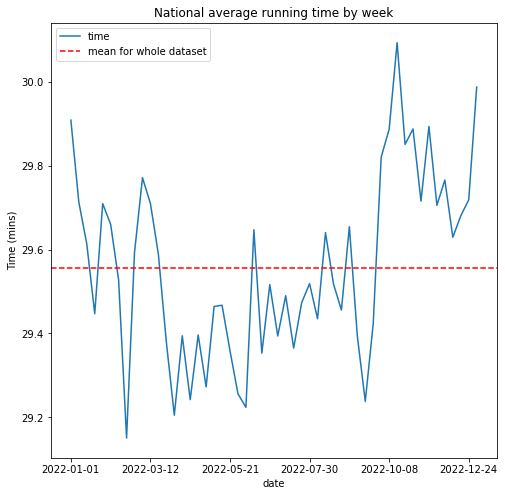

In [188]:
airruns.groupby('date')['time'].mean().plot(figsize = (8,8))
plt.axhline(y = airruns.time.mean(), color = 'r', linestyle = 'dashed', label = "mean for whole dataset")
plt.title("National average running time by week")
plt.legend()
plt.ylabel("Time (mins)");

The pollutants all seem to have some slight collinearity, though ozone has a negative correlation with nitric oxide and nitrogen dioxide. As for time, it seems to have a negative correlation with male (which goes against the findings from earlier, but could be because the majority of the dataset is male and there's a lot of outliers) and a low poisitive correlation with age.
This is likely because there's a wide spread of times even within gender and age groups, which suggests some feature engineering to separate running ability based on time.  After all, the biggest predictor for running time is likely to be running ability and the other variables will probably only have smaller effects.


In [39]:
airruns.drop('level', inplace = True, axis = 1)

# Model Fitting

### Creating and cleaning a sample for the model

In [268]:
# create a sample that is 1% of the original, large dataset with an equal amount of ages and genders
sample = airruns.groupby(['parkrun', 'date'], group_keys=False).apply(lambda x: x.sample(frac=0.01))
sample

,name,time,parkrun,race_num,date,year,is_male,med_age,location,co,no,no2,o3,so2,pm2_5,pm10,nh3,county,lat,lon
1305899,James HARRISON,23.816667,aberbeeg,85,2022-01-29,2022,1,37.0,Aberbeeg,226.97,0.00,2.14,66.52,1.01,1.64,3.34,0.19,Blaenau Gwent,51.709543,-3.144626
1305863,Claire TIDEY,31.133333,aberbeeg,86,2022-02-05,2022,0,42.0,Aberbeeg,247.00,0.01,3.98,67.95,1.48,0.82,2.09,0.69,Blaenau Gwent,51.709543,-3.144626
1305766,David E WILLIAMS,22.566667,aberbeeg,87,2022-02-12,2022,1,57.0,Aberbeeg,240.33,0.02,5.10,74.39,1.97,1.29,3.18,1.30,Blaenau Gwent,51.709543,-3.144626
1305692,Fiona CLOUGH,30.300000,aberbeeg,89,2022-03-05,2022,0,62.0,Aberbeeg,250.34,0.52,4.46,64.37,1.03,4.07,4.38,3.61,Blaenau Gwent,51.709543,-3.144626
1305603,Alex LOHFINK,22.933333,aberbeeg,90,2022-03-12,2022,1,62.0,Aberbeeg,243.66,0.13,4.93,72.24,1.18,1.01,1.66,1.46,Blaenau Gwent,51.709543,-3.144626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274757,Anita RUDDOCK,24.516667,york,438,2022-12-24,2022,0,62.0,York,190.26,0.00,1.86,55.79,0.44,1.28,2.03,0.55,North Yorkshire,54.377342,-0.887987
2274220,Neil BROOKFIELD,21.300000,york,440,2022-12-31,2022,1,37.0,York,193.60,0.01,4.67,25.39,0.66,1.14,1.42,1.55,North Yorkshire,54.377342,-0.887987
2274185,Tom HULL,19.166667,york,440,2022-12-31,2022,1,27.0,York,193.60,0.01,4.67,25.39,0.66,1.14,1.42,1.55,North Yorkshire,54.377342,-0.887987
2274214,David BANNISTER,20.716667,york,440,2022-12-31,2022,1,52.0,York,193.60,0.01,4.67,25.39,0.66,1.14,1.42,1.55,North Yorkshire,54.377342,-0.887987


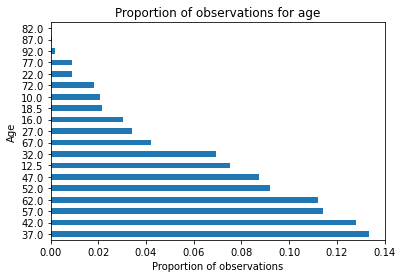

In [269]:
# check the age breakdown for the whole dataframe
sample['med_age'].value_counts(normalize = True).plot(kind = 'barh')
plt.yticks(ticks = range(sample['med_age'].nunique()), labels = (sample['med_age'].unique()), rotation =0)
plt.ylabel("Age")
plt.xlabel("Proportion of observations")
plt.title("Proportion of observations for age")
plt.show();

In [103]:
# now start to handle the variables for creating X and y and model fitting
sample.dtypes

name         object
time        float64
parkrun      object
race_num      int64
date         object
year          int64
is_male       int64
med_age     float64
location     object
co          float64
no          float64
no2         float64
o3          float64
so2         float64
pm2_5       float64
pm10        float64
nh3         float64
county       object
lat         float64
lon         float64
dtype: object

In [270]:
# name can be dropped for X, as can race number, date, year, location, county, lat, and lon.  So let's drop them now:

sample.drop(['name', 'race_num', 'date', 'year', 'location', 'county', 'lat', 'lon'], axis = 1, inplace = True)

sample.head()

,time,parkrun,is_male,med_age,co,no,no2,o3,so2,pm2_5,pm10,nh3
1305899,23.816667,aberbeeg,1,37.0,226.97,0.00,2.14,66.52,1.01,1.64,3.34,0.19
1305863,31.133333,aberbeeg,0,42.0,247.00,0.01,3.98,67.95,1.48,0.82,2.09,0.69
1305766,22.566667,aberbeeg,1,57.0,240.33,0.02,5.10,74.39,1.97,1.29,3.18,1.30
1305692,30.300000,aberbeeg,0,62.0,250.34,0.52,4.46,64.37,1.03,4.07,4.38,3.61
1305603,22.933333,aberbeeg,1,62.0,243.66,0.13,4.93,72.24,1.18,1.01,1.66,1.46


In [271]:
sample.parkrun.nunique()

615

The question now is what to do with the parkrun variable.  There are a few parkruns that are faster and a few that are slower, however this could be as much down to overall number of samples from each parkrun, air quality 
(which we have data for) & proportion of age range running at that location. Which we have data for. 
Plus, dummifying that many locations to create 600 more columns will not make our model run quickly!

In [106]:
sample.drop('parkrun', axis = 1, inplace = True)
sample.head()

,time,is_male,med_age,co,no,no2,o3,so2,pm2_5,pm10,nh3
1305897,23.300000,1,47.0,226.97,0.00,2.14,66.52,1.01,1.64,3.34,0.19
1305814,18.333333,1,47.0,247.00,0.01,3.98,67.95,1.48,0.82,2.09,0.69
1305773,25.616667,1,52.0,240.33,0.02,5.10,74.39,1.97,1.29,3.18,1.30
1305681,27.333333,1,42.0,250.34,0.52,4.46,64.37,1.03,4.07,4.38,3.61
1305643,33.000000,0,47.0,243.66,0.13,4.93,72.24,1.18,1.01,1.66,1.46


In [108]:
sample.columns

Index(['time', 'is_male', 'med_age', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5',
       'pm10', 'nh3'],
      dtype='object')

### Scaling Data

The pollutants and age are all different scales and units to each other.  This could affect their unfairly importance to the models.  But scaling them should make it easier for the models to utilise the data.

In [109]:
# finally, we need to standard scale the age & the pollution data, 

scaler = StandardScaler()

sample[['med_age', 'co', 'no', 'no2', 'o3', 
        'so2','pm2_5', 'pm10', 'nh3']] = scaler.fit_transform(sample[['med_age', 'co', 'no', 
                                                                      'no2', 'o3', 'so2',
                                                                      'pm2_5', 'pm10', 'nh3']])

In [110]:
sample.head()

,time,is_male,med_age,co,no,no2,o3,so2,pm2_5,pm10,nh3
1305897,23.300000,1,0.185667,0.299699,-0.348416,-0.783020,0.726228,-0.617207,-0.571167,-0.579642,-0.516732
1305814,18.333333,1,0.185667,0.727957,-0.346919,-0.557440,0.800350,-0.452268,-0.678387,-0.723428,-0.358346
1305773,25.616667,1,0.513420,0.585347,-0.345423,-0.420130,1.134162,-0.280311,-0.616931,-0.598047,-0.165115
1305681,27.333333,1,-0.142086,0.799369,-0.270610,-0.498593,0.614784,-0.610188,-0.253429,-0.460012,0.566629
1305643,33.000000,0,0.185667,0.656545,-0.328964,-0.440971,1.022718,-0.557548,-0.653543,-0.772891,-0.114431


In [254]:
sample.to_csv("sample.csv")

In [273]:
# define X and y
y = sample.time
X = sample[['is_male', 'med_age', 'co', 'no', 'no2', 'o3', 'so2',
       'pm2_5', 'pm10', 'nh3']]

print(X.shape)
print(y.shape)

(43662, 10)
(43662,)


In [274]:
# creating train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30563, 10) (30563,)
(13099, 10) (13099,)


### Time for the actual models

Since the target variables is a float with a large range and cannot be put into category, we need to use regressor models:

## Linear Regressor

In [ ]:
# instantiate model

lrmodel = LinearRegression()

#fit on training data

lrmodel.fit(X_train, y_train)

#score on training and test data

lrtrainscore = lrmodel.score(X_train, y_train)

lrtestscore = lrmodel.score(X_test, y_test)

print(f"training score of LR model is {lrtrainscore}")

# cross validate scores

lrcv_scores = cross_val_score(lrmodel, X_train, y_train, cv=5)

print(f"cv scores for lr model {lrcv_scores}")
print(f"mean lr model cv scores {np.mean(lrcv_scores)}")

lrtestscore = lrmodel.score(X_test, y_test)

print(f"test score of {lrtestscore}")

print("MSE :" , metrics.mean_squared_error(y_test, lrmodel.predict(X_test)))

### Regularization with Elastic Net

LinearRegressor can be regularized using either Ridge or Lasso, which both introduce a little noise into the sample (that's the alpha value) and then use slightly different methods to adjust importance of the variables to improve the model's fit.  ElasticNet can combine the two in one go, by varying the l1 ratio

In [276]:
# not great R2 scores, can elasticnetcv improve it?

# define a range of l1 ratios to try
l1_ratios = np.linspace(0.1, 1.0, 25)

# give ElasticNetCV this range of L1 ratios and a number of alphas to try.  We don't want to give it too much to do
# as it can be quite a slow computational process
# define this model with our optimal l1 ratio and alpha as our optimal Enet model
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1, n_jobs=2)

# fit our optimal Enet to the training set
optimal_enet.fit(X_train, y_train)

#print out the alpah and l1 ratio of the optimal 
print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.019413318840848064
1.0


In [277]:
enettrain = optimal_enet.score(X_train, y_train)
enettest = optimal_enet.score(X_test, y_test)

print('Original model train score was: ', lrtrainscore)
print('Original model test score was: ', lrtestscore)
print('Enet train score is: ', enettrain)
print('Enet test score is: ', enettest)

Original model train score was:  0.18960281727147477
Original model test score was:  0.18074474167720134
Enet train score is:  0.18956651376811617
Enet test score is:  0.18083965121992163


### Coefficients & residuals

The model applies a coefficient to each variable, with the magnitude of the variable indicating importance of the variable. Whether it is negative or positive indicates whether the relationship between the variable and the target is proportional or inversely proportional

The residuals will show where the model is differing from the actual values - is it tending to predict too high, too low etc

In [278]:
# pretty much the same, but what coefficients is it basing it on?

Enet_coefs = pd.DataFrame({'variable': X_train.columns,
                            'coef': optimal_enet.coef_,
                            'abs_coef': np.abs(optimal_enet.coef_)})

Enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)

Enet_coefs

,variable,coef,abs_coef
0,is_male,-5.668833,5.668833
1,med_age,0.090056,0.090056
6,so2,-0.046428,0.046428
4,no2,0.018716,0.018716
3,no,-0.012338,0.012338
7,pm2_5,-0.003129,0.003129
2,co,-0.001056,0.001056
8,pm10,-0.000990,0.000990
5,o3,0.000614,0.000614
9,nh3,0.000000,0.000000


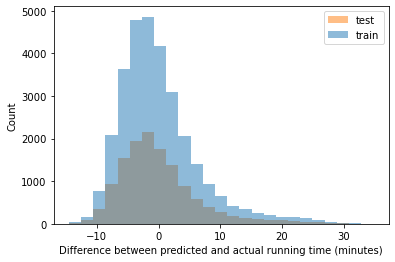

In [314]:
#primarily gender and age!
# what are the residuals like?
residtrain = y_train - optimal_enet.predict(X_train)
residtest = y_test - optimal_enet.predict(X_test)

plt.hist([residtrain, residtest], bins=25, histtype='stepfilled', alpha=0.5)
plt.legend(['test', 'train'])
plt.xlabel("Difference between actual and predicted running time (minutes)")
plt.ylabel("Count")
plt.show()

The residuals seem to peak in the lower negative values, suggesting that on the majority of cases, the model overestimates the running time.  However, there is a long positive tail.  This shows that there are a few runs that are quite drastically underestimated.  This could well be due to the range of the running times present in the dataset.

## Decision Tree models

Decision trees tend to work better on non-linear target variables than LinearRegression.

In [279]:
# what if we use a decision tree?

tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

treetrainscore = tree.score(X_train, y_train)

treetestscore = tree.score(X_test, y_test)

print(f"training score of DTR model is {treetrainscore}")

treecv_scores = cross_val_score(tree, X_train, y_train, cv=5)

print(f"cv scores for DTR model {treecv_scores}")
print(f"mean DTR model cv scores {np.mean(treecv_scores)}")

treetestscore = tree.score(X_test, y_test)

print(f"test score of {treetestscore}")

training score of DTR model is 0.9590934844310537
cv scores for DTR model [-0.60131258 -0.5745314  -0.59678794 -0.60186331 -0.61791919]
mean DTR model cv scores -0.5984828862318856
test score of -0.5753710945945043


A really high training score was promising! It can effectively account for alomst 96& of all observed variance.

However, decision trees have a tendancy to overfit to the training data and when looking at the test data scores, this is clearly what has happened, as these scores are actually negative.  

### Feature Importances

Much like the coefficients from linear regression, the feature importances will tell us how which variables the model tends to make decisions on (how it splits samples from one another)

In [281]:
# what are the feature importances?
features = pd.DataFrame({'variable': X_train.columns,
                            'importance': tree.feature_importances_})
features.sort_values('importance', inplace=True, ascending=False)
features

,variable,importance
0,is_male,0.158038
1,med_age,0.119115
4,no2,0.099674
6,so2,0.096229
9,nh3,0.095081
5,o3,0.090966
8,pm10,0.090295
7,pm2_5,0.089333
2,co,0.082018
3,no,0.079251


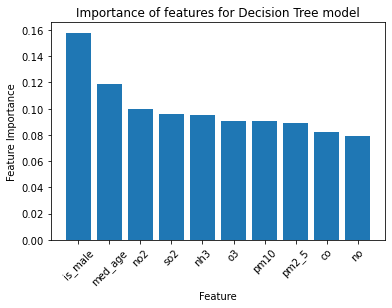

In [286]:
plt.bar(features.variable, height = features.importance)
plt.xticks(ticks = range(0,10), labels = features.variable, rotation = 45)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Importance of features for Decision Tree model");

So in both the linear regressor and decision tree models, gender is the greatest predictor, followed by age.  However, they have quite different importances or coefficients for the pollutants.  For example, ammonia has the highest importance, while it has the lowest coefficient for linear regression

### Parameter tuning

Decision trees have a range of parameters we can use to imrpove the model, we can use GridSearchCV to test out a number of these parameters to see if any will give an improved score, in particular on the test data

In [255]:
# the test scores and cv scores suggest it's overfit on training data. 
from sklearn.model_selection import GridSearchCV

param_grid = {"criterion": ["squared_error", "absolute_error"],
              "min_samples_split": [10, 20, 40],
              "min_samples_leaf": [1, 5, 20, 40],
              "max_leaf_nodes": [5, 20, 35 50],
              }

grid_cv_tree = GridSearchCV(tree, param_grid, cv=5)

grid_cv_tree.fit(X_train,y_train)

grid_tree_score = grid_cv_tree.score(X_train, y_train)

grid_tree_params = grid_cv_tree.best_params_

grid_tree_test = grid_cv_tree.score(X_test, y_test)


print(f"R-Squared :{grid_tree_score}")
print(f"Best Hyperparameters \n: {grid_tree_params}")
print(f"Test score = {grid_tree_test}")

R-Squared :0.24219325157774962
Best Hyperparameters 
: {'criterion': 'squared_error', 'max_leaf_nodes': 20, 'min_samples_leaf': 40, 'min_samples_split': 20}
Test score = 0.24395502028696925


The training data score has dropped from almost 0.96 to 0.24, which is a drastic worsening in our model.  At least on the training data, as on the test data the score is improved - firstly it's actually positive! - and it's slightly better than the training score.

This suggests that using the above parameters makes for an overall better model than the original.

### Feature Importances

Since this model is less overfit, let's look at what the decisions are based on

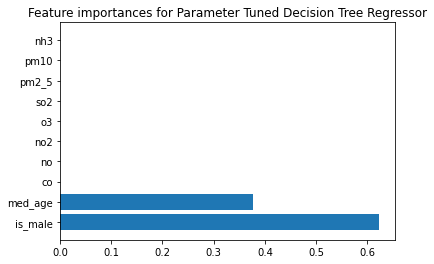

In [315]:
best_tree = grid_cv_tree.best_estimator_

features = pd.DataFrame({'variable': X_train.columns,
                            'importance': best_tree.feature_importances_})
features.sort_values('importance', inplace=True, ascending=False)

plt.barh(features.variable, features.importance)
plt.title("Feature importances for Parameter Tuned Decision Tree Regressor");

These are not the features I am looking for.  Ideally we would have seen an increase in the importance of the pollutants - or at least one.  But in reality the parameter tuning has meant that the decision tree model is basing it's predictions entirely on gender and age



## Random Forest Regressor

RandomForests use a group of decision trees to make predictions, connecting together the different models that each have different 'strengths' - each model being more effective in a different situation or variable than the others

In [293]:
forest = RandomForestRegressor(n_estimators = 40, n_jobs = 6)
forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=40, n_jobs=6)

In [294]:
forest_train_score = forest.score(X_train, y_train)

forest_test_score = forest.score(X_test, y_test)

print(f"training score of RF model is {forest_train_score}")

forestcv_scores = cross_val_score(forest, X_train, y_train, cv=5)

print(f"cv scores for RF model {forestcv_scores}")
print(f"mean RF model cv scores {np.mean(forestcv_scores)}")

forest_test_score = forest.score(X_test, y_test)

print(f"test score of {forest_test_score}")

training score of RF model is 0.8479603025138988
cv scores for RF model [0.14203605 0.13050482 0.1526706  0.1324382  0.1393234 ]
mean RF model cv scores 0.13939461430096786
test score of 0.14005847702103758


Much like the original decision tree model, the random forest model shows an overfit on the training data.  It is however, less overfit than the decision tree.  Which is a positive sign.

### Feature Importances

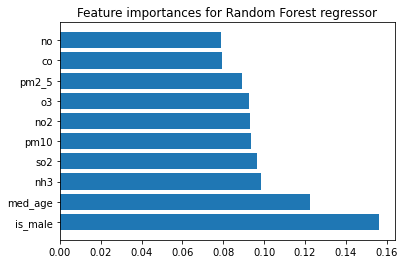

In [302]:
forest_features = pd.DataFrame({'variable': X_train.columns,
                            'importance': forest.feature_importances_})
forest_features.sort_values('importance', inplace=True, ascending=False)

plt.barh(forest_features.variable, forest_features.importance)
plt.title("Feature importances for Random Forest regressor");

Again gender and age are the most 'important' features according to the random forest model.  Let's use gridsearch, much like with the decision tree, to find the optimal parameters to create the optimal model:

### Parameter Tuning

In [304]:
param_grid = {"criterion": ["squared_error"],
              "min_samples_split": [10, 20],
              "min_samples_leaf": [1, 20, 40],
              "max_leaf_nodes": [2, 10, 20],
              "n_estimators" : [40]}

grid_cv_forest = GridSearchCV(forest, param_grid, cv=5, n_jobs = 6)

grid_cv_forest.fit(X_train,y_train)

grid_forest_score = grid_cv_forest.score(X_train, y_train)

grid_forest_params = grid_cv_forest.best_params_

grid_forest_test = grid_cv_forest.score(X_test, y_test)


print(f"R-Squared :{grid_forest_score}")
print(f"Best Hyperparameters \n: {grid_forest_params}")
print(f"Test score = {grid_forest_test}")

R-Squared :0.24377011604895427
Best Hyperparameters 
: {'criterion': 'squared_error', 'max_leaf_nodes': 20, 'min_samples_leaf': 40, 'min_samples_split': 20, 'n_estimators': 40}
Test score = 0.2405228331380539


The scores are remarkably similar to those from the tuned decision tree.  Indeed the parameters are exactly the same.  Which may mean they are almost exactly the same model under the hood!

Finally, let's check the feature importances:


### Feature Importances

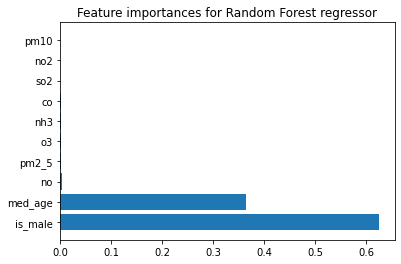

In [308]:
best_forest = grid_cv_forest.best_estimator_

best_forest_features = pd.DataFrame({'variable': X_train.columns,
                            'importance': best_forest.feature_importances_})
best_forest_features.sort_values('importance', inplace=True, ascending=False)

plt.barh(best_forest_features.variable, best_forest_features.importance)
plt.title("Feature importances for Random Forest regressor");

It's quite possible that these two models are the same - or very very close to being the same - under the hood, as the feature importances are the same!


# Evaluation

At this stage it feels we have exhausted our modelling options unless we go back and do some more feature engineering and loop back through, or bring in some new data...

Which means that future work could involve adding in weather data, scaling the pollutant data in a different manner or engineering it into an air quality index

Otherwise the models suggest that air pollution data can't be used to predict running times.  The most reliable models - when taking into account the test and training data scores and thus the durability of the model on unseen data - the parameter tuned decision tree and random forest models, give us R^2 scores 0.24, well off what we would normally be looking for.
However, this could be due the sheer range in abilities contained within the original dataset or those not contained within in it.